# 네이버 영화 리뷰 감성 분류
- LSTM 활용
- 데이터 다운로드 링크 https://github.com/e9t/nsmc/

In [1]:
# Konlpy 설치
!pip install Konlpy

     |████████████████████████████████| 19.4MB 1.2MB/s 
     |████████████████████████████████| 92kB 14.8MB/s 
     |████████████████████████████████| 460kB 51.8MB/s 
  Found existing installation: tweepy 3.6.0
    Uninstalling tweepy-3.6.0:
      Successfully uninstalled tweepy-3.6.0
  Found existing installation: beautifulsoup4 4.6.3
    Uninstalling beautifulsoup4-4.6.3:
      Successfully uninstalled beautifulsoup4-4.6.3


In [2]:
import konlpy
konlpy.__version__

'0.5.2'

In [3]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [4]:
seed = 2021
np.random.seed(seed)
tf.random.set_seed(seed)

### 파일 업로드

In [5]:
from google.colab import files

uploaded = files.upload()
filename = list(uploaded.keys())[0]

Saving ratings_train.txt to ratings_train.txt


In [6]:
uploaded = files.upload()
testfile = list(uploaded.keys())[0]

Saving ratings_test.txt to ratings_test.txt


### 데이터 전처리

In [11]:
import pandas as pd
train_df = pd.read_table(filename)
test_df = pd.read_table(testfile)

In [12]:
train_df.shape

(150000, 3)

In [13]:
train_df.head(3)

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0


In [14]:
train_df['document'].nunique()

146182

In [15]:
train_df.drop_duplicates(subset=['document'], inplace=True)
train_df.shape

(146183, 3)

In [16]:
train_df = train_df.dropna(how='any')
train_df.shape

(146182, 3)

In [17]:
train_df.head(3)

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0


- 테스트 데이터 셋도 똑같이 적용

In [18]:
test_df.drop_duplicates(subset=['document'], inplace=True)
test_df = test_df.dropna(how='any')

In [19]:
test_df.head(3)

,id,document,label
0,6270596,굳 ㅋ,1
1,9274899,GDNTOPCLASSINTHECLUB,0
2,8544678,뭐야 이 평점들은.... 나쁘진 않지만 10점 짜리는 더더욱 아니잖아,0


### 한글 텍스트 전처리

In [20]:
# 한글과 공백을 제외하고 모두 제거
train_df['document'] = train_df['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
train_df.head(3)

,id,document,label
0,9976970,아 더빙 진짜 짜증나네요 목소리,0
1,3819312,흠포스터보고 초딩영화줄오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0


In [21]:
train_df['document'].replace('', np.nan, inplace=True)
train_df.isnull().sum()

id            0
document    391
label         0
dtype: int64

In [22]:
train_df = train_df.dropna(how='any')
train_df.shape

(145791, 3)

- 테스트 데이터 셋에도 똑같이 적용

In [23]:
test_df['document'] = test_df['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
test_df['document'].replace('', np.nan, inplace=True)
test_df.isnull().sum()

id            0
document    162
label         0
dtype: int64

In [24]:
test_df = test_df.dropna(how='any')
test_df.shape

(48995, 3)

In [25]:
from konlpy.tag import Okt

In [26]:
# 토큰화와 불용어 제거
import tqdm.notebook as tn
stopwords=['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']
okt = Okt()

X_train=[]
for sentence in tn.tqdm(train_df['document']):
    temp_X = []
    temp_X = okt.morphs(sentence, stem=True) # 토큰화
    temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
    X_train.append(temp_X)

In [27]:
X_test=[]
for sentence in tn.tqdm(test_df['document']):
    temp_X = []
    temp_X = okt.morphs(sentence, stem=True) # 토큰화
    temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
    X_test.append(temp_X)

In [28]:
X_train[:3]

[['아', '더빙', '진짜', '짜증나다', '목소리'],
 ['흠', '포스터', '보고', '초딩', '영화', '줄', '오버', '연기', '조차', '가볍다', '않다'],
 ['너', '무재', '밓었', '다그', '래서', '보다', '추천', '다']]

In [29]:
# 정수 인코딩
max_words = 35000
tokenizer = Tokenizer(num_words=max_words) # 상위 35,000개의 단어만 보존
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [30]:
X_train[:3]

[[50, 454, 16, 260, 659],
 [933, 457, 41, 602, 1, 214, 1449, 24, 961, 675, 19],
 [386, 2444, 25015, 2315, 5671, 2, 222, 9]]

In [31]:
# 전체 데이터의 길이 분포
print('리뷰의 최대 길이 :', max(len(s) for s in X_train))
print('리뷰의 평균 길이 :', sum(map(len, X_train))/len(X_train))

리뷰의 최대 길이 : 69
리뷰의 평균 길이 : 10.911133060339802


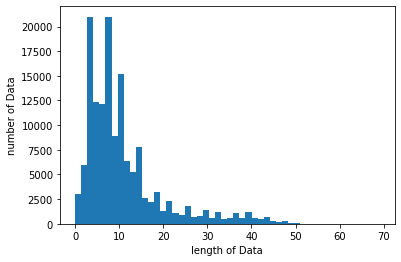

In [32]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.hist([len(s) for s in X_train], bins=50)
plt.xlabel('length of Data')
plt.ylabel('number of Data')
plt.show()

In [33]:
#  X_train과 X_test의 모든 샘플의 길이를 동일하게 30으로 셋팅
max_len=30
# 전체 데이터의 길이는 30으로 맞춘다.
X_train = pad_sequences(X_train, maxlen=max_len)
X_test = pad_sequences(X_test, maxlen=max_len)

In [34]:
y_train = np.array(train_df['label'])
y_test = np.array(test_df['label'])

### 1. LSTM

In [35]:
from tensorflow.keras.layers import Embedding, Dense, LSTM
from tensorflow.keras.models import Sequential

In [36]:
model = Sequential()
model.add(Embedding(max_words, 100))
model.add(LSTM(128))
model.add(Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 100)         3500000   
_________________________________________________________________
lstm (LSTM)                  (None, 128)               117248    
_________________________________________________________________
dense (Dense)                (None, 1)                 129       
Total params: 3,617,377
Trainable params: 3,617,377
Non-trainable params: 0
_________________________________________________________________


In [37]:
model.compile(loss='binary_crossentropy', 
              optimizer='adam',
              metrics=['accuracy'])

In [38]:
from keras.callbacks import ModelCheckpoint
checkpointer = ModelCheckpoint(filepath='naver-lstm-best-model.h5', 
                               monitor='val_loss', verbose=1, save_best_only=True)

In [39]:
history = model.fit(X_train, y_train, epochs=4, batch_size=60,
                    validation_split=0.2, verbose=1, callbacks=[checkpointer])

Epoch 1/4
1944/1944 [==============================] - 75s 34ms/step - loss: 0.4371 - accuracy: 0.7915 - val_loss: 0.3494 - val_accuracy: 0.8473

Epoch 00001: val_loss improved from inf to 0.34942, saving model to naver-lstm-best-model.h5
Epoch 2/4
1944/1944 [==============================] - 67s 35ms/step - loss: 0.2828 - accuracy: 0.8815 - val_loss: 0.3411 - val_accuracy: 0.8528

Epoch 00002: val_loss improved from 0.34942 to 0.34115, saving model to naver-lstm-best-model.h5
Epoch 3/4
1944/1944 [==============================] - 65s 34ms/step - loss: 0.2240 - accuracy: 0.9097 - val_loss: 0.3799 - val_accuracy: 0.8493

Epoch 00003: val_loss did not improve from 0.34115
Epoch 4/4
1944/1944 [==============================] - 64s 33ms/step - loss: 0.1762 - accuracy: 0.9288 - val_loss: 0.4259 - val_accuracy: 0.8453

Epoch 00004: val_loss did not improve from 0.34115


In [41]:
# Best Model 선택
from tensorflow.keras.models import load_model
best_model = load_model('naver-lstm-best-model.h5')

In [42]:
acc = best_model.evaluate(X_test, y_test, verbose=2)[1]
print(f'Accuracy: {acc:.4f}')

1532/1532 - 4s - loss: 0.3487 - accuracy: 0.8486
Accuracy: 0.8486


In [43]:
# 테스트셋
y_vloss = history.history['val_loss']
y_vacc = history.history['val_accuracy']
# 학습셋
y_loss = history.history['loss']
y_acc = history.history['accuracy']

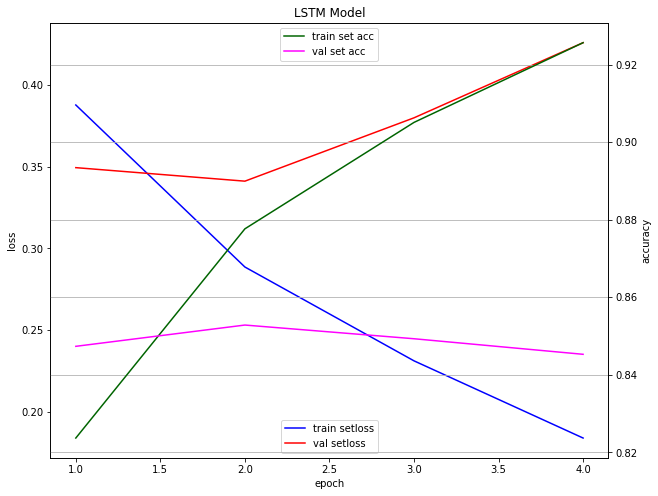

In [45]:
x_len = np.arange(1, len(y_loss)+1)
fig, ax0 = plt.subplots(figsize=(10,8))
ax1 = ax0.twinx()
ax0.plot(x_len, y_loss, c="blue", label='train setloss')
ax0.plot(x_len, y_vloss, c="red", label='val setloss')
ax0.set_ylabel('loss')
ax1.plot(x_len, y_acc, c="darkgreen", label='train set acc')
ax1.plot(x_len, y_vacc, c="magenta", label='val set acc')
ax1.set_ylabel('accuracy')
ax0.set_xlabel('epoch')
ax0.legend(loc='lower center')
ax1.legend(loc='upper center')
plt.title('LSTM Model')
plt.grid()
plt.show()

### 2. SimpleRNN

In [46]:
from tensorflow.keras.layers import SimpleRNN
model2 = Sequential()
model2.add(Embedding(max_words, 100))
model2.add(SimpleRNN(128))
model2.add(Dense(1, activation='sigmoid'))
model2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 100)         3500000   
_________________________________________________________________
simple_rnn (SimpleRNN)       (None, 128)               29312     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 129       
Total params: 3,529,441
Trainable params: 3,529,441
Non-trainable params: 0
_________________________________________________________________


In [49]:
model2.compile(loss='binary_crossentropy', 
              optimizer='adam', metrics=['accuracy'])
checkpointer = ModelCheckpoint(filepath='naver-rnn-best-model.h5', 
                               monitor='val_loss', verbose=1, save_best_only=True)
history2 = model2.fit(X_train, y_train, epochs=4, batch_size=60,
                      validation_split=0.2, verbose=1, callbacks=[checkpointer])

Epoch 1/4
1944/1944 [==============================] - 97s 49ms/step - loss: 0.4641 - accuracy: 0.7656 - val_loss: 0.3702 - val_accuracy: 0.8400

Epoch 00001: val_loss improved from inf to 0.37023, saving model to naver-rnn-best-model.h5
Epoch 2/4
1944/1944 [==============================] - 94s 48ms/step - loss: 0.3099 - accuracy: 0.8708 - val_loss: 0.3766 - val_accuracy: 0.8375

Epoch 00002: val_loss did not improve from 0.37023
Epoch 3/4
1944/1944 [==============================] - 94s 48ms/step - loss: 0.2227 - accuracy: 0.9116 - val_loss: 0.4343 - val_accuracy: 0.8192

Epoch 00003: val_loss did not improve from 0.37023
Epoch 4/4
1944/1944 [==============================] - 94s 48ms/step - loss: 0.1659 - accuracy: 0.9368 - val_loss: 0.5352 - val_accuracy: 0.8176

Epoch 00004: val_loss did not improve from 0.37023


In [50]:
best_model2 = load_model('naver-rnn-best-model.h5')
acc = best_model2.evaluate(X_test, y_test, verbose=2)[1]
print(f'Accuracy: {acc:.4f}')

1532/1532 - 5s - loss: 0.3773 - accuracy: 0.8343
Accuracy: 0.8343


### 3. LSTM + CNN

In [53]:
from tensorflow.keras.layers import Conv1D, Dropout, MaxPooling1D
model3 = Sequential()
model3.add(Embedding(max_words, 100))
model3.add(Dropout(0.5))
model3.add(Conv1D(64, 5, padding='valid', activation='relu'))
model3.add(MaxPooling1D(pool_size=4))
model3.add(LSTM(60))
model3.add(Dense(1, activation='sigmoid'))
model3.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, None, 100)         3500000   
_________________________________________________________________
dropout_2 (Dropout)          (None, None, 100)         0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, None, 64)          32064     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, None, 64)          0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 60)                30000     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 61        
Total params: 3,562,125
Trainable params: 3,562,125
Non-trainable params: 0
____________________________________________

In [54]:
model3.compile(loss='binary_crossentropy', 
              optimizer='adam', metrics=['accuracy'])
checkpointer = ModelCheckpoint(filepath='naver-cnn-lstm-best-model.h5', 
                               monitor='val_loss', verbose=1, save_best_only=True)
history3 = model3.fit(X_train, y_train, epochs=4, batch_size=60,
                      validation_split=0.2, verbose=1, callbacks=[checkpointer])

Epoch 1/4
1944/1944 [==============================] - 65s 32ms/step - loss: 0.5384 - accuracy: 0.7013 - val_loss: 0.4469 - val_accuracy: 0.7765

Epoch 00001: val_loss improved from inf to 0.44695, saving model to naver-cnn-lstm-best-model.h5
Epoch 2/4
1944/1944 [==============================] - 60s 31ms/step - loss: 0.4033 - accuracy: 0.8071 - val_loss: 0.4421 - val_accuracy: 0.7810

Epoch 00002: val_loss improved from 0.44695 to 0.44210, saving model to naver-cnn-lstm-best-model.h5
Epoch 3/4
1944/1944 [==============================] - 62s 32ms/step - loss: 0.3519 - accuracy: 0.8330 - val_loss: 0.4616 - val_accuracy: 0.7778

Epoch 00003: val_loss did not improve from 0.44210
Epoch 4/4
1944/1944 [==============================] - 62s 32ms/step - loss: 0.3132 - accuracy: 0.8519 - val_loss: 0.4912 - val_accuracy: 0.7776

Epoch 00004: val_loss did not improve from 0.44210


In [55]:
best_model3 = load_model('naver-cnn-lstm-best-model.h5')
acc = best_model3.evaluate(X_test, y_test, verbose=2)[1]
print(f'Accuracy: {acc:.4f}')

1532/1532 - 3s - loss: 0.4511 - accuracy: 0.7754
Accuracy: 0.7754
